## Description 

Smoothing Example Notebook

This notebook provides example code based on the lecture material.

If you wish to run or edit the notebook, we recommend downloading it and running it either on your local machine or on JupyterHub.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm

%matplotlib inline 

In [3]:
diab = pd.read_csv("../data/diabetes.csv")
print("""
# Variables are
# subject: subject ID number
# age: age diagnosed with diabetes
# acidity: a measure of acidity called base deficit
# y: natural log of serum C-peptide concentration
# Original source is Sockett et al. (1987)
# mentioned in Hastie and Tibshirani's book 
# "Generalized Additive Models".
"""
)
diab.head()


# Variables are
# subject: subject ID number
# age: age diagnosed with diabetes
# acidity: a measure of acidity called base deficit
# y: natural log of serum C-peptide concentration
# Original source is Sockett et al. (1987)
# mentioned in Hastie and Tibshirani's book 
# "Generalized Additive Models".



,subject,age,acidity,y
0,1,5.2,-8.1,4.8
1,2,8.8,-16.1,4.1
2,3,10.5,-0.9,5.2
3,4,10.6,-7.8,5.5
4,5,10.4,-29.0,5.0


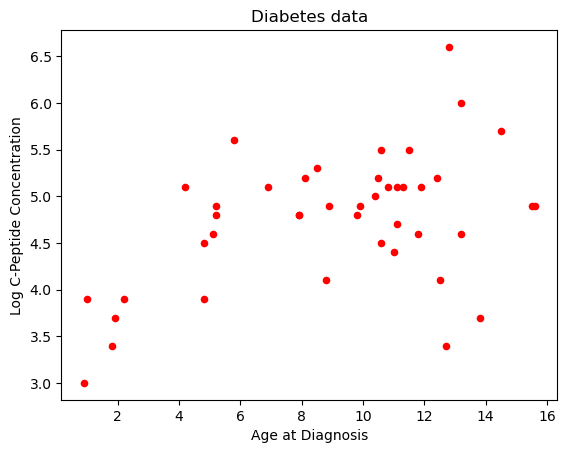

In [4]:
diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data")
plt.xlabel("Age at Diagnosis")
plt.ylabel("Log C-Peptide Concentration")
plt.show()

## Linear Regression
After a lot of time with SKLearn, we're moving back to Statsmodels because of its fuller implementation of statistical tools, like confidence intervals.

We'll also be using statsmodels' powerful formula interface. It lets one write complex models succinctly and without building complex design matrices by hand. Below, we write `'y~age'` to mean "the y column is approximately $\beta_1$ times the age column (plus a constant $\beta_0$". We could include more columns, or transformations of the age column, e.g. '`y ~ age + age**2 + acidity'`.

In [5]:
fit1_lm = sm.ols('y~age',data=diab).fit()

We create a very dense set of values to predict on. Remember: the _point_ of a model is to provide outputs for a wide variety of inputs. No need to only predict on the training or test values-- the model can predict on anything you ask it to!

Further, it's *important when working with statsmodels that we make a named data frame*- if we only use a numpy array statsmodels won't know it's the 'age' variable.

!!!!!!!!

In [6]:
xpred = pd.DataFrame({"age":np.arange(0,16.1,0.1)})

Plot the prediction line and confidence intervals

In [7]:
pred1 = fit1_lm.predict(xpred)
# pred1 is a Series
prediction_output = fit1_lm.get_prediction(xpred).summary_frame()
# fit1_lm.get_prediction(xpred) is the instance statsmodels.regression._prediction.PredictionResults
prediction_output.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.996031,0.244590,3.502071,4.489991,2.600828,5.391235
1,4.004340,0.242324,3.514957,4.493723,2.610750,5.397929
2,4.012648,0.240062,3.527834,4.497463,2.620656,5.404640
3,4.020957,0.237804,3.540703,4.501211,2.630547,5.411367
4,4.029266,0.235550,3.553562,4.504969,2.640421,5.418111


Above, we use `fitted_model.get_prediction().summary_frame()` to get predictions _and_ confidence intervals.

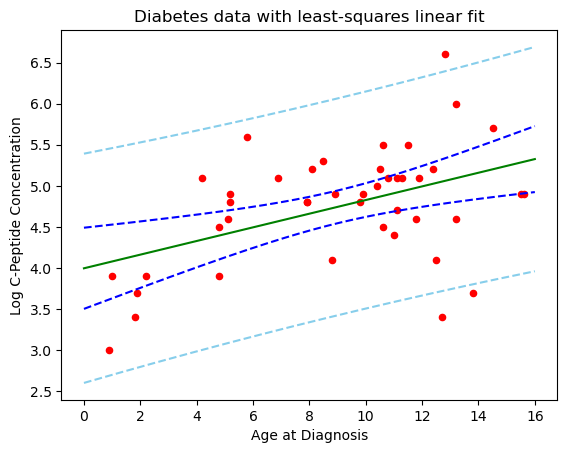

In [11]:
ax1 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data with least-squares linear fit")
ax1.set_xlabel("Age at Diagnosis")
ax1.set_ylabel("Log C-Peptide Concentration")

ax1.plot(xpred.age, prediction_output['mean'],color="green")

# CI for the predection at each x value, i.e. the line itself
ax1.plot(xpred.age, prediction_output['mean_ci_lower'], color="blue",linestyle="dashed")
ax1.plot(xpred.age, prediction_output['mean_ci_upper'], color="blue",linestyle="dashed");

# CIs for where future data will fall
ax1.plot(xpred.age, prediction_output['obs_ci_lower'], color="skyblue",linestyle="dashed")
ax1.plot(xpred.age, prediction_output['obs_ci_upper'], color="skyblue",linestyle="dashed");

# It combines the uncertainty about the mean estimate with the randomness of a new observation for given mean. 
# It assumes that residuals are distributed close to normal distribution, uses either normal or t distribution for the prediction interval and is therefore only approximate. 
# mean_ci is the confidence interval for the expected value or mean x * beta_hat given the standard errors of the parameter estimates, i.e. essentially a confidence interval for the regression line. 
# obs_ci is essentially a confidence interval for ``x * beta_hat + error`

### Polynomial Regression
In sklearn we would use polynomial_features. Here we use `vander` to build the matrix of transformed inputs. In particular, `vander` is a numpy function and therefore usable directly in the formula- it saves us from writing out `y ~ age + age**2 + age**3 + ...` and so on.

`vander` is for Vandermonde. It's a matrix where the first column is $x^0$, the second is $x^1$, the third is $x^2$ and so on.

` np.vander([6,3,5], 4, increasing=True) =                                 
                                            array([[  1,   6,  36, 216],  
                                                   [  1,   3,   9,  27],  
                                                   [  1,   5,  25, 125]])
`  

Since we have a constant column in the matrix, we put a -1 in the formula to drop the additional constant term statsmodels would otherwise insert

Note that this is **not** an _orthogonal_ polynomial basis. Our estimated coefficients will be more sensitive to the data than they need to be.

!!!!!!!!!!!!

In [13]:
# *cubic* polynomial (vander's input is one more than the degree)
fit2_lm = sm.ols(formula="y ~ np.vander(age, 4, increasing=True) -1",data=diab).fit()
# the same model written out explicitly
fit2_lm_long = sm.ols(formula="y ~ age + np.power(age, 2) + np.power(age, 3)",data=diab).fit()

poly_predictions = fit2_lm.get_prediction(xpred).summary_frame()
poly_predictions

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.740481,0.508197,1.712556,3.768406,1.156238,4.324724
1,2.806326,0.486091,1.823115,3.789538,1.250724,4.361929
2,2.870902,0.464764,1.930827,3.810977,1.342198,4.399606
3,2.934219,0.444219,2.035702,3.832737,1.430714,4.437725
4,2.996291,0.424456,2.137747,3.854835,1.516327,4.476255
...,...,...,...,...,...,...
156,5.020575,0.362481,4.287387,5.753763,3.609632,6.431518
157,5.031705,0.379499,4.264095,5.799315,3.602572,6.460837
158,5.043414,0.397195,4.240011,5.846817,3.594742,6.492087
159,5.055716,0.415572,4.215142,5.896290,3.586104,6.525328


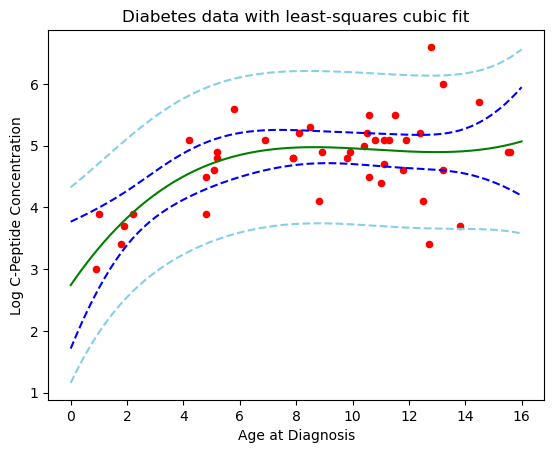

In [14]:
ax2 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data with least-squares cubic fit")
ax2.set_xlabel("Age at Diagnosis")
ax2.set_ylabel("Log C-Peptide Concentration")

# CI for the predection at each x value, i.e. the curve itself
ax2.plot(xpred.age, poly_predictions['mean'],color="green")
ax2.plot(xpred.age, poly_predictions['mean_ci_lower'], color="blue",linestyle="dashed")
ax2.plot(xpred.age, poly_predictions['mean_ci_upper'], color="blue",linestyle="dashed");

# CIs for where future data will fall
ax2.plot(xpred.age, poly_predictions['obs_ci_lower'], color="skyblue",linestyle="dashed")
ax2.plot(xpred.age, poly_predictions['obs_ci_upper'], color="skyblue",linestyle="dashed");

## Logistic Regression
Statsmodels provides logistic regression via the same formula-based interface.

For the sake of doing logistic regression, suppose we have the binary outcome "Was y above 4?"

In [15]:
diab['y_bin'] = 1*(diab['y'] > 4) # multiply by 1 because statsmodels wants 1s and 0s instead of true and false

In [16]:
logit_model = sm.logit("y_bin ~ age", data = diab).fit()
logit_prediction = logit_model.predict(xpred)

Optimization terminated successfully.
         Current function value: 0.353988
         Iterations 7


In [24]:
fit2_lm.params

np.vander(age, 4, increasing=True)[0]    2.740481
np.vander(age, 4, increasing=True)[1]    0.664841
np.vander(age, 4, increasing=True)[2]   -0.064079
np.vander(age, 4, increasing=True)[3]    0.001976
dtype: float64

There is no built-in `get_predictions` for logistic regression. The code provided below can be used as a replacement. Because it was custom-written by your loving TFs, it will handle polynomial models that use `vander`, but little else. 

In [22]:
fit2_lm.cov_params()

,"np.vander(age, 4, increasing=True)[0]","np.vander(age, 4, increasing=True)[1]","np.vander(age, 4, increasing=True)[2]","np.vander(age, 4, increasing=True)[3]"
"np.vander(age, 4, increasing=True)[0]",0.258264,-0.114323,0.013768,-0.000492
"np.vander(age, 4, increasing=True)[1]",-0.114323,0.062685,-0.008274,0.000312
"np.vander(age, 4, increasing=True)[2]",0.013768,-0.008274,0.001149,-0.000045
"np.vander(age, 4, increasing=True)[3]",-0.000492,0.000312,-0.000045,0.000002


In [26]:
from scipy.special import expit
import re
def get_logit_prediction_intervals(model, new_data_df):
    if type(new_data_df) != pd.DataFrame:
        raise TypeError('new_data_df must be a DataFrame')
    
    # transform the raw data according to the formula
    new_data_dict = {}
    for x in model.params.index:
        # only presently supports Intercept, a named column, and polynmoials created via np.vander
        # the trick is finding the correct base column in the raw data
        if x == "Intercept":
            new_data_dict[x] = np.ones(new_data_df.shape[0])
        elif x.startswith("np.vander("):
            try:
                will = re.match(r"np.vander\((.*), ?(.*)\)\[(.*)\]", x)
                column, power, index = will.groups()
            except Exception:
                raise ValueError("Couldn't parse formula-derived feature {}".format(x))
            new_data_dict[x] = np.vander(new_data_df.loc[:,column], int(power))[:,int(index)]
        else:
            new_data_dict[x] = new_data_df.loc[:,x]
    new_data = pd.DataFrame(new_data_dict)
    
    variance_mat = model.cov_params()
    # estimated covariance matrix of the regression coefficients in a fitted model.
    # the diagonal elements will not necessarily be 1. The diagonal elements represent the variances of the regression coefficients, not the correlation between them.
    standard_devs = np.sqrt(np.sum(new_data.dot(variance_mat) * new_data, axis=1))
    # 1^2 * var(intercept) + 2*a1 *cov(age, intercept) + a1^2 * var(age)
    
    
    linear_predictions = new_data.dot(model.params)
    output = pd.DataFrame({"lower": expit(linear_predictions - 1.96*standard_devs),
                  "predicted": expit(linear_predictions),
                  "upper": expit(linear_predictions + 1.96*standard_devs)
                 })
    # expit: The expit function, also known as the logistic sigmoid function, is defined as expit(x) = 1/(1+exp(-x)). 
    return output

logit_prediction_intervals = get_logit_prediction_intervals(logit_model, xpred)
logit_prediction_intervals

,lower,predicted,upper
0,0.046716,0.230382,0.646460
1,0.049354,0.236818,0.649700
2,0.052128,0.243377,0.652945
3,0.055044,0.250058,0.656198
4,0.058108,0.256860,0.659458
...,...,...,...
156,0.867631,0.987899,0.999018
157,0.869055,0.988322,0.999074
158,0.870462,0.988729,0.999128
159,0.871853,0.989123,0.999178


A pure logistic model

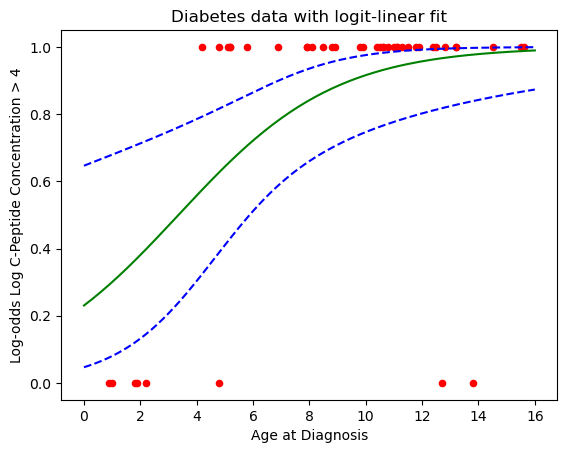

In [27]:
ax = diab.plot.scatter(x='age',y='y_bin',c='Red',title="Diabetes data with logit-linear fit")
ax.set_xlabel("Age at Diagnosis")
ax.set_ylabel("Log-odds Log C-Peptide Concentration > 4")

ax.plot(xpred.age, logit_prediction_intervals["predicted"],color="green")
ax.plot(xpred.age, logit_prediction_intervals["lower"], color="blue",linestyle="dashed")
ax.plot(xpred.age, logit_prediction_intervals["upper"], color="blue",linestyle="dashed");
plt.show()

A logistic model wherein the probability is a cubic function of Age

In [28]:
logit_poly_model = sm.logit("y_bin ~ np.vander(age, 4) - 1", data = diab).fit()
logit_poly_prediction = logit_poly_model.predict(xpred)

Optimization terminated successfully.
         Current function value: 0.194005
         Iterations 10


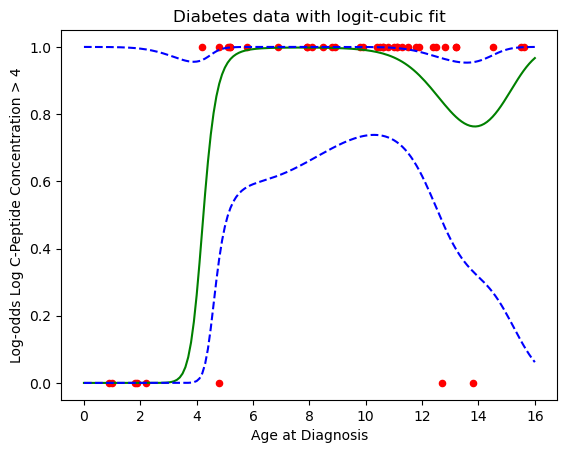

In [29]:
ax = diab.plot.scatter(x='age',y='y_bin',c='Red',title="Diabetes data with logit-cubic fit")
ax.set_xlabel("Age at Diagnosis")
ax.set_ylabel("Log-odds Log C-Peptide Concentration > 4")

logit_poly_prediction_intervals = get_logit_prediction_intervals(logit_poly_model, xpred)

ax.plot(xpred.age, logit_poly_prediction_intervals["predicted"],color="green")
ax.plot(xpred.age, logit_poly_prediction_intervals["lower"], color="blue",linestyle="dashed")
ax.plot(xpred.age, logit_poly_prediction_intervals["upper"], color="blue",linestyle="dashed");
plt.show()

## Lo(w)ess
Lowess is available in Statsmodels. It takes a fraction of the data that should be used in smoothing each point.  Please note that you are not responsible for mastering lowess - this is merely for your edification.

In [30]:
from statsmodels.nonparametric.smoothers_lowess import lowess as lowess

lowess_models = {}
for cur_frac in [.15,.25,.7, 1]:
    lowess_models[cur_frac] = lowess(diab['y'],diab['age'],frac=cur_frac)

In [34]:
lowess_models

{0.15: array([[ 0.9       ,  3.22071129],
        [ 1.        ,  3.26459047],
        [ 1.8       ,  3.62356396],
        [ 1.9       ,  3.66837986],
        [ 2.2       ,  3.80550938],
        [ 4.2       ,  5.0920864 ],
        [ 4.8       ,  4.19014581],
        [ 4.8       ,  4.19014581],
        [ 5.1       ,  4.66468111],
        [ 5.2       ,  4.82679775],
        [ 5.2       ,  4.82679775],
        [ 5.8       ,  5.60413944],
        [ 6.9       ,  5.15776522],
        [ 7.9       ,  4.85093204],
        [ 7.9       ,  4.85093204],
        [ 8.1       ,  5.02835902],
        [ 8.5       ,  5.1296147 ],
        [ 8.8       ,  4.91174383],
        [ 8.9       ,  4.85636973],
        [ 9.8       ,  4.82794726],
        [ 9.9       ,  4.86508221],
        [10.4       ,  5.06013779],
        [10.5       ,  5.11628607],
        [10.6       ,  5.1415741 ],
        [10.6       ,  5.1415741 ],
        [10.8       ,  5.00035972],
        [11.        ,  4.86404852],
        [11.1       , 

**Note** Python's lowess implementation does not have any tool to predict on new data; it only returns the fitted function's value at the training points. We're making up for that by drawing a straight line between consecutive fitted values (scipy's `interp1d`). (There are other more sophisticated interpolation techniques, but the ideal approach would be to predict on new points using lowess itself. This is a limitation of the Python implementation, not lowess itself. R, for example, has a much fuller Lowess toolkit)

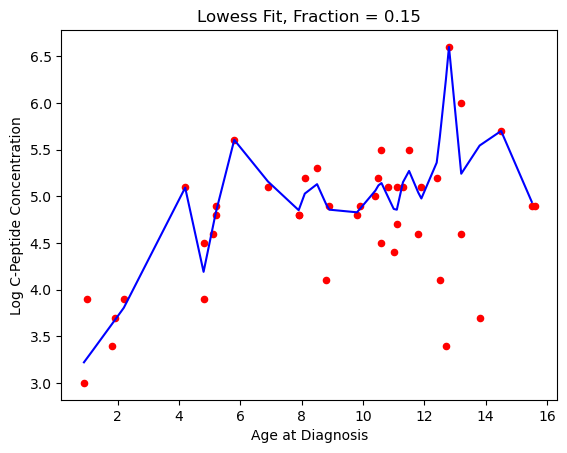

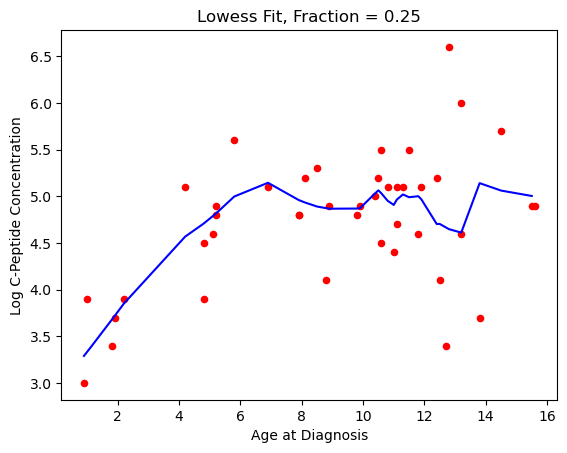

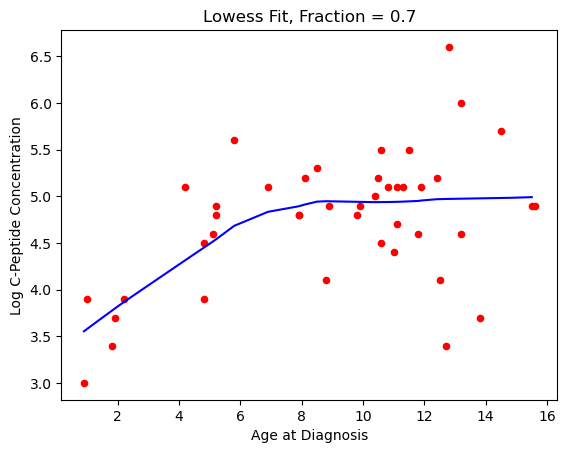

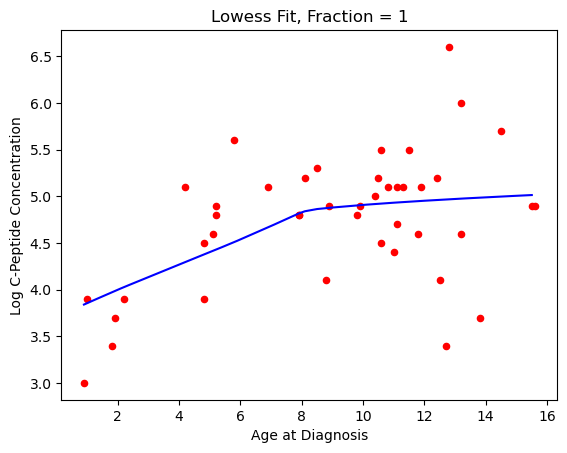

In [31]:
from scipy.interpolate import interp1d
for cur_frac, cur_model in lowess_models.items():
    ax = diab.plot.scatter(x='age',y='y',c='Red',title="Lowess Fit, Fraction = {}".format(cur_frac))
    # title can be set within ax
    ax.set_xlabel("Age at Diagnosis")
    ax.set_ylabel("Log C-Peptide Concentration")
    lowess_interpolation = interp1d(cur_model[:,0], cur_model[:,1], bounds_error=False)
    # bounds_error, If True, a ValueError is raised any time interpolation is attempted on a value outside of the range of x (where extrapolation is necessary). 
    # If False, out of bounds values are assigned fill_value. 
    # defaul: kind='linear'
    # https://en.wikipedia.org/wiki/Interpolation
    ax.plot(xpred, lowess_interpolation(xpred), color="Blue")
    plt.show()

As the fraction of data increases, Lowess moves from high-variance to high-bias

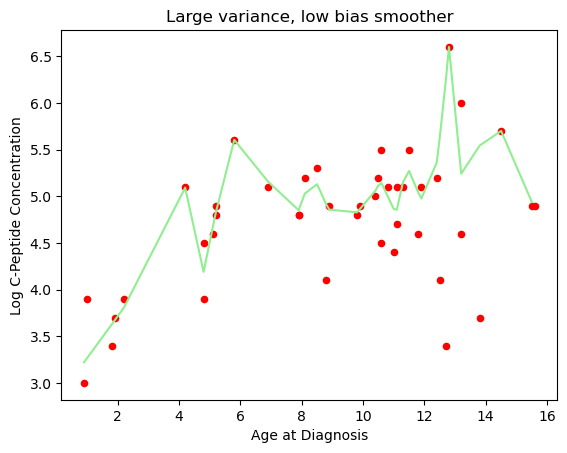

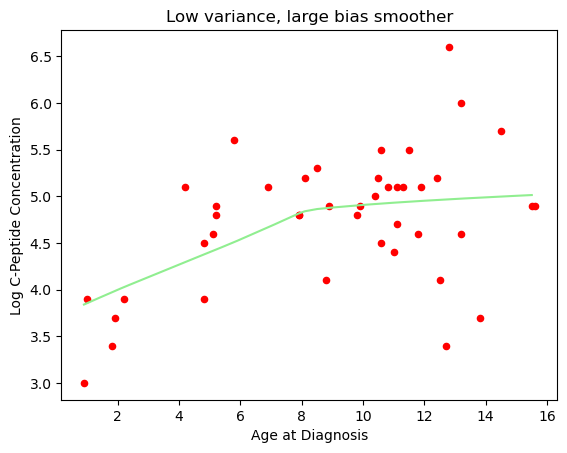

In [32]:
ax = diab.plot.scatter(x='age',y='y',c='Red',title="Large variance, low bias smoother")
ax.set_xlabel("Age at Diagnosis")
ax.set_ylabel("Log C-Peptide Concentration")
lowess_interpolation = interp1d(lowess_models[.15][:,0], lowess_models[.15][:,1], bounds_error=False)
ax.plot(xpred, lowess_interpolation(xpred), color="lightgreen")
plt.show()

ax = diab.plot.scatter(x='age',y='y',c='Red',title="Low variance, large bias smoother")
ax.set_xlabel("Age at Diagnosis")
ax.set_ylabel("Log C-Peptide Concentration")
lowess_interpolation = interp1d(lowess_models[1][:,0], lowess_models[1][:,1], bounds_error=False)
ax.plot(xpred, lowess_interpolation(xpred), color="lightgreen")
plt.show()

## Splines (via knots)
Here, we flash back to OLS and logistic regression. So far, we've made "design" matrices by taking powers of the raw data's columns and asking the solver "how much of each transformed column is there"? That's fine if there's an a-priori theoretical reason to think the relationship truly is polynomial. But in most cases we can use *much* richer and better transformations of the raw data

The function below is one such better transformation of the raw data. It (depending on the parameters) applies a RELU or truncated cubic to the input data. Let's see what that looks like

In [35]:
def h(x, knot, exponent):
    output = np.power(x-knot, exponent)
    output[x<=knot] = 0
    
    return output

Transforming the x values [0,10] with a knot at 4, power 1. Everything below 4 is zeroed out, values above 4 increase at slope 1. (If we had applied "square the data" we'd see a parabola below)

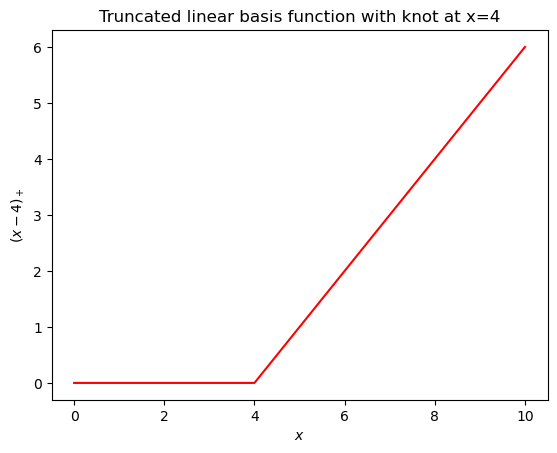

In [37]:
xvals = np.arange(0,10.1,0.1)

plt.plot(xvals, h(xvals,4,1), color="red")
plt.title("Truncated linear basis function with knot at x=4")
plt.xlabel("$x$")
plt.ylabel("$(x-4)_+$") #note the use of TeX in the label
plt.show()

Transforming the x values [0,10] with a knot at 4, power 3. Again, inputs below 4 are zeroed out, the rest grow cubically with their distance from 4.

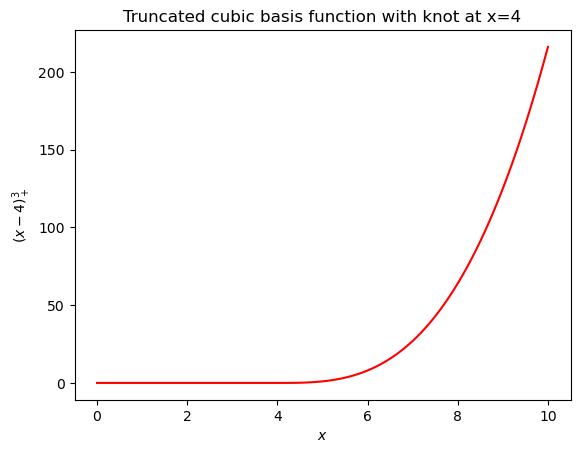

In [40]:
plt.plot(xvals,h(xvals,4,3),color="red")
plt.title("Truncated cubic basis function with knot at x=4")
plt.xlabel("$x$")
plt.ylabel("$(x-4)_+^3$")
plt.show()

The sum of three RELUs with different knots and different coefficients can create a complicated shape, and thus fit complicated data. Below we see $3\cdot RELU(x,\text{knot=}2) - 4\cdot RELU(x,\text{knot=}5) + 0.5\cdot RELU(x,\text{knot=}8)$. Can you see how much the slope changes at each knot (i.e. at 2, 5, and 8)? 

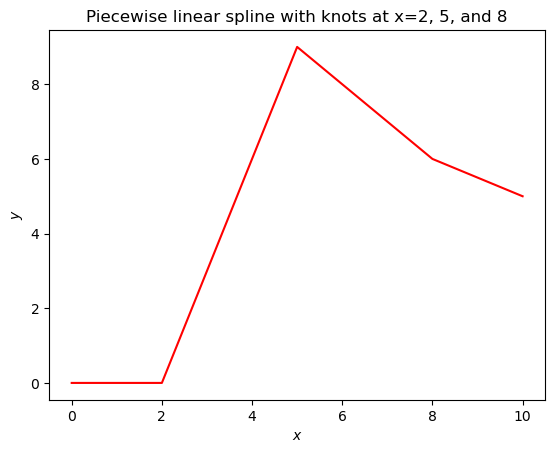

In [41]:
plt.plot(xvals, 3*h(xvals,2,1) - 4*h(xvals,5,1) + 0.5*h(xvals,8,1), color="red")
plt.title("Piecewise linear spline with knots at x=2, 5, and 8")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

Above, but with a starting slope and intercept  
(intercept=2, starting slope=1)

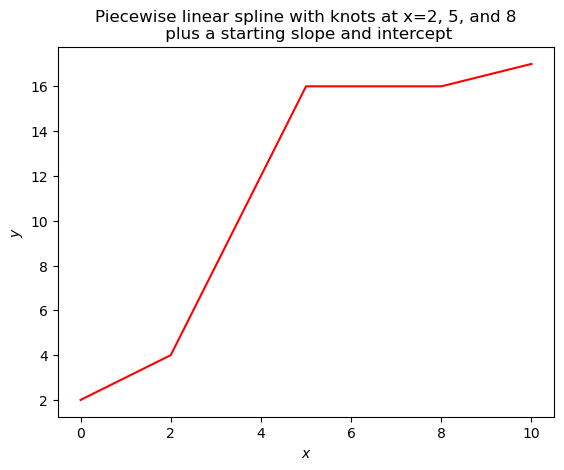

In [42]:
plt.plot(xvals, 2 + xvals + 3*h(xvals,2,1) - 4*h(xvals,5,1) + 0.5*h(xvals,8,1), color="red")
plt.title("Piecewise linear spline with knots at x=2, 5, and 8\n plus a starting slope and intercept")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

Using OLS, we can find optimal coefficients for RELUs with pre-specified knots, just like we can find optimal coefficients for $x^2$ and $x^3$

In [49]:
# generate some fake data to fit

x = np.arange(0.1,10,9.9/100) 
from scipy.stats import norm
y = norm.ppf(x/10) + np.random.normal(0,0.4,100)
# ppf The "percent point function" is a mathematical concept related to probability distributions. 
# It refers to a function that gives the value corresponding to a specified percentile or quantile of a distribution.
# Given a probability distribution and a probability value p between 0 and 1, 
# the percent point function calculates the value x such that the probability of observing a value less than or equal to x is equal to p.

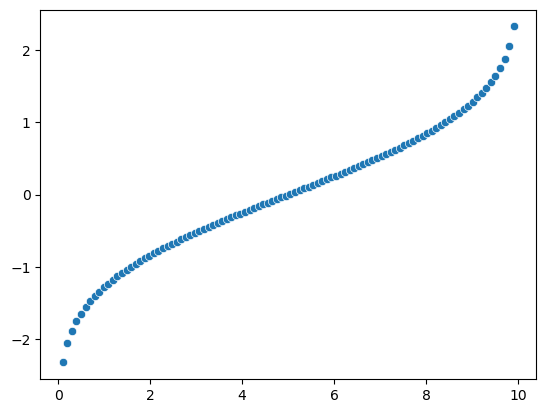

In [60]:
import seaborn as sns

_ = sns.scatterplot(x = x, y = norm.ppf(x/10))

Notice that we can apply the function h(x) directly in the formula, because we defined it earlier in the notebook.

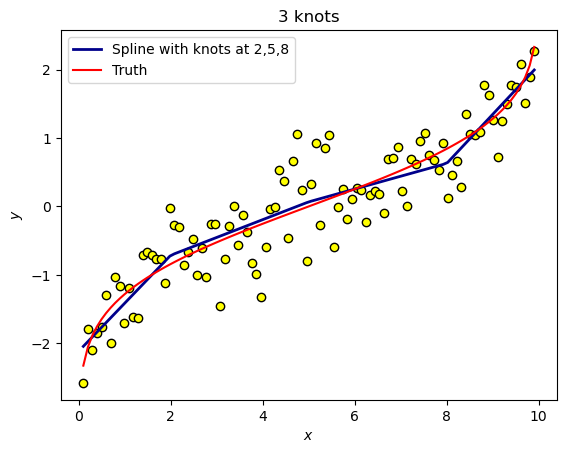

In [59]:
fitted_spline_model = sm.ols('y~x+h(x,2,1)+h(x,5,1)+h(x,8,1)',data={'x':x,'y':y}).fit()
# another way to fit
# !!!!!!!!!!!!

plt.scatter(x,y,facecolors='None', edgecolors='black')
# !!!!! how to set the color of markers

plt.title("3 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", linewidth=2, label="Spline with knots at 2,5,8")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

More knots

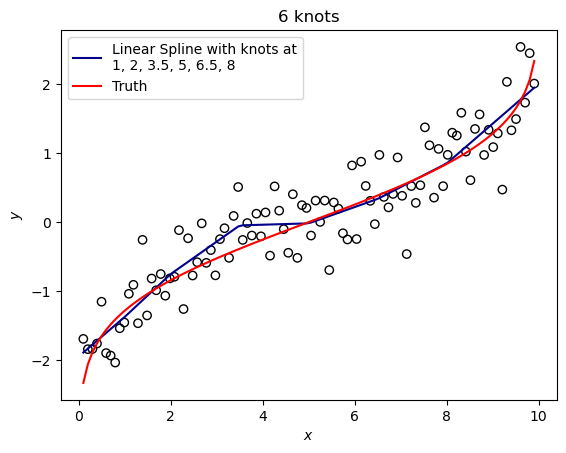

In [45]:
fitted_spline_model = sm.ols('y~x+h(x,1,1)+h(x,2,1)+h(x,3.5,1)+h(x,5,1)+h(x,6.5,1)+h(x,8,1)',data={'x':x,'y':y}).fit()

plt.scatter(x,y,facecolors='none', edgecolors='black')
plt.title("6 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", label="Linear Spline with knots at\n1, 2, 3.5, 5, 6.5, 8")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

More knots (writing out all the knots in this formula is getting old...)

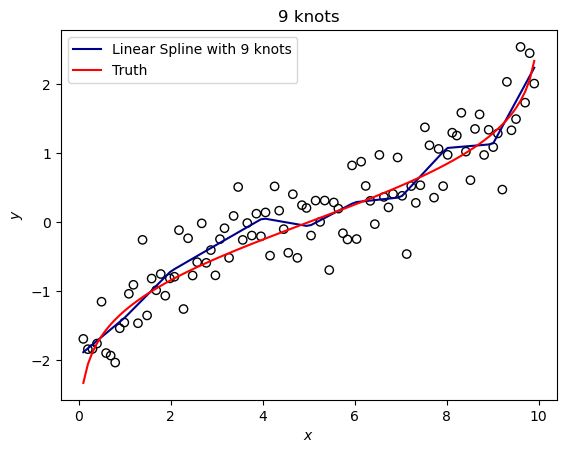

In [46]:
fitted_spline_model = sm.ols('y~x+h(x,1,1)+h(x,2,1)+h(x,3,1)+h(x,4,1)+h(x,5,1)+h(x,6,1)+h(x,7,1)+h(x,8,1)+h(x,9,1)',
                             data={'x':x,'y':y}).fit()

plt.scatter(x,y,facecolors='none', edgecolors='black')
plt.title("9 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", label="Linear Spline with 9 knots")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

Using code to write out the formula this time. Comments provided for those who are new to python

In [62]:
n_knots = 25

# make a list of strings that each look like 'h(x,?,1)' where ? takes the values in np.linspace(0,10,n_knots)
components = ['h(x,{},1)'.format(x) for x in np.linspace(0,10,n_knots)]
# glue all the strings in 'components' together with " + " between each
formula = ' + '.join(components)
# paste a 'y ~ x + ' in front of the above. Now we've got a full formula!
final_formula = 'y ~ x + ' + formula

final_formula

'y ~ x + h(x,0.0,1) + h(x,0.4166666666666667,1) + h(x,0.8333333333333334,1) + h(x,1.25,1) + h(x,1.6666666666666667,1) + h(x,2.0833333333333335,1) + h(x,2.5,1) + h(x,2.916666666666667,1) + h(x,3.3333333333333335,1) + h(x,3.75,1) + h(x,4.166666666666667,1) + h(x,4.583333333333334,1) + h(x,5.0,1) + h(x,5.416666666666667,1) + h(x,5.833333333333334,1) + h(x,6.25,1) + h(x,6.666666666666667,1) + h(x,7.083333333333334,1) + h(x,7.5,1) + h(x,7.916666666666667,1) + h(x,8.333333333333334,1) + h(x,8.75,1) + h(x,9.166666666666668,1) + h(x,9.583333333333334,1) + h(x,10.0,1)'

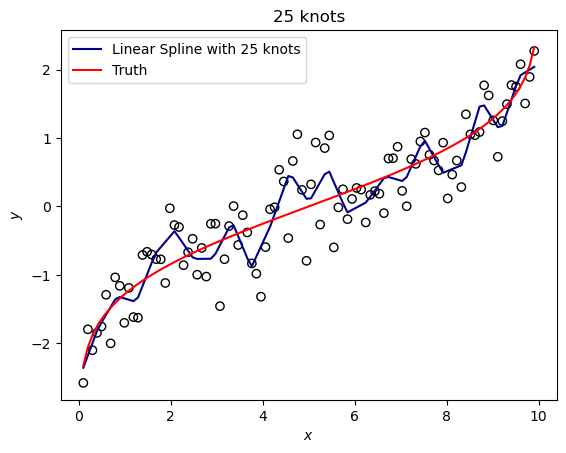

In [63]:
fitted_spline_model = sm.ols(final_formula,data={'x':x,'y':y}).fit()

plt.scatter(x,y,facecolors='none', edgecolors='black')
plt.title("25 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", label="Linear Spline with 25 knots")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

Cubic splines, instead of linear. Still using code to write the formula. [Knots at 2,5,8, each one cubic; starting intercept, slope, acceleration, and jerk]

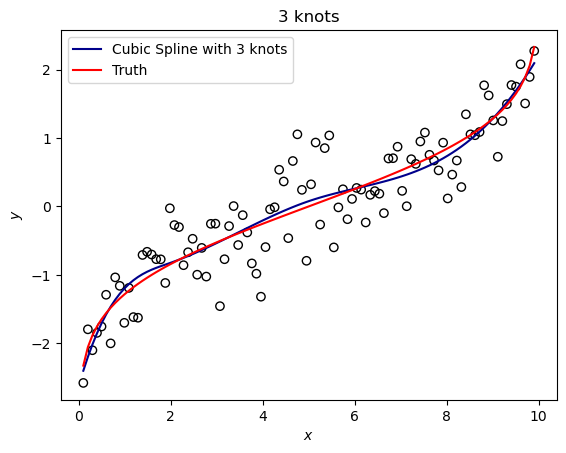

In [64]:
components = ['h(x,{},3)'.format(x) for x in [2,5,8]]
formula = ' + '.join(components)
final_formula = 'y~x + np.power(x,2) + np.power(x,3) + ' + formula

fitted_spline_model = sm.ols(final_formula,data={'x':x,'y':y}).fit()

plt.scatter(x,y,facecolors='none', edgecolors='black')
plt.title("3 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", label="Cubic Spline with 3 knots")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

As above, but with more knots (a more flexible fit)

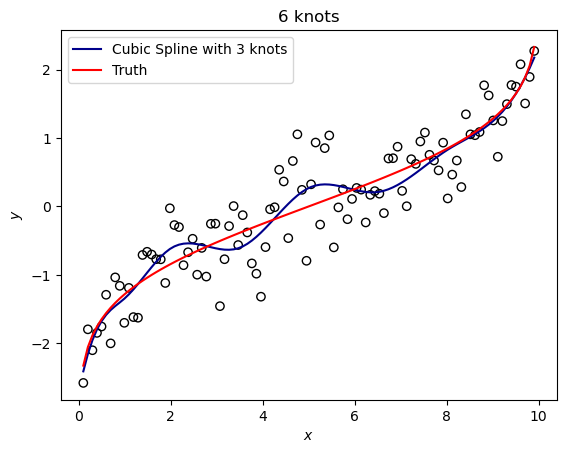

In [65]:
components = ['h(x,{},3)'.format(x) for x in [1,2,3.5,5,6.5,8]]
formula = ' + '.join(components)
final_formula = 'y~x + np.power(x,2) + np.power(x,3) + ' + formula

fitted_spline_model = sm.ols(final_formula,data={'x':x,'y':y}).fit()

plt.scatter(x,y,facecolors='none', edgecolors='black')
plt.title("6 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", label="Cubic Spline with 3 knots")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

More knots

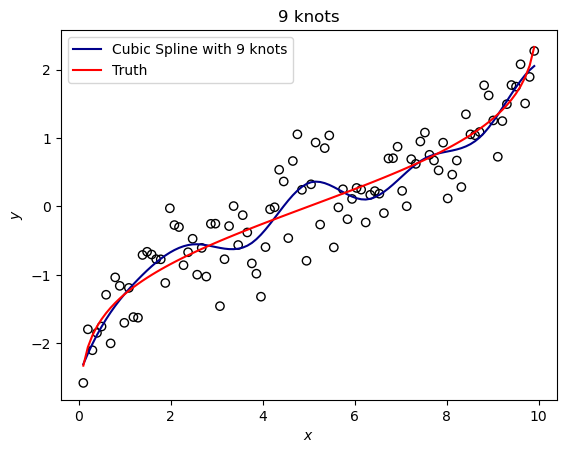

In [66]:
n_knots = 9
components = ['h(x,{},3)'.format(x) for x in np.linspace(0,10,n_knots)]
formula = ' + '.join(components)
final_formula = 'y~x + np.power(x,2) + np.power(x,3) + ' + formula

fitted_spline_model = sm.ols(final_formula,data={'x':x,'y':y}).fit()

plt.scatter(x,y,facecolors='none', edgecolors='black')
plt.title("9 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", label="Cubic Spline with 9 knots")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

Even more knots.  As with the linear splines, this looks like it is overfitting a lot.

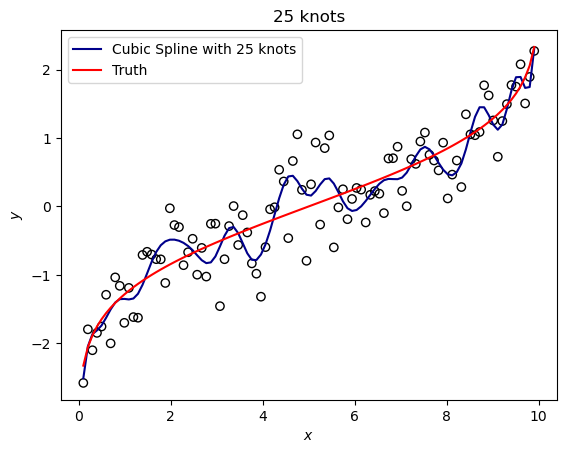

In [67]:
n_knots = 25
components = ['h(x,{},3)'.format(x) for x in np.linspace(0,10,n_knots)]
formula = ' + '.join(components)
final_formula = 'y~x + np.power(x,2) + np.power(x,3) + ' + formula

fitted_spline_model = sm.ols(final_formula,data={'x':x,'y':y}).fit()

plt.scatter(x,y,facecolors='none', edgecolors='black')
plt.title("25 knots")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(x, fitted_spline_model.predict(),color="darkblue", label="Cubic Spline with 25 knots")
plt.plot(x, norm.ppf(x/10), color="red", label="Truth")
plt.legend()
plt.show()

It turns out that the *number* of knots matters far more than *where* they are placed. You can play with the code above to verify if you wish.

## Smoothing splines
Smoothing splines, as described in class, minimize the sum of squared errors subject to a penalty that depends on the wiggliness of the function.  The resulting solution is a cubic spline with knots at every data value that is regularized according to a smoothing parameter.

We use the csaps library to implement smoothing splines.  The smoothing parameter takes on values between 0 and 1, and is the weight attached to the error sum of squares of the weighted average between the error sum of squares and the wiggliness penalty.  A smoothing parameter of 0 correspondends to a least-squares fit, and a parameter of 1 corresponds to connecting-the-dots.

In [71]:
import matplotlib.pyplot as plt
from csaps import csaps
# Cubic Spline Approximation (Smoothing)


Read in csaps to carry out smoothing splines.

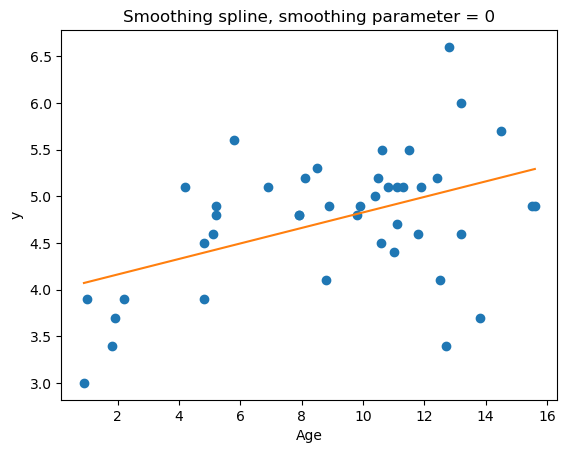

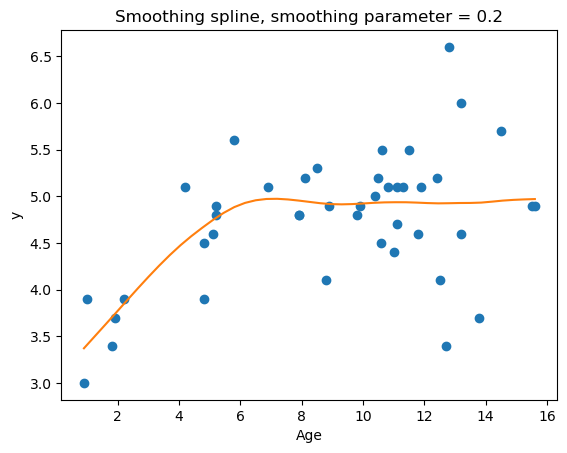

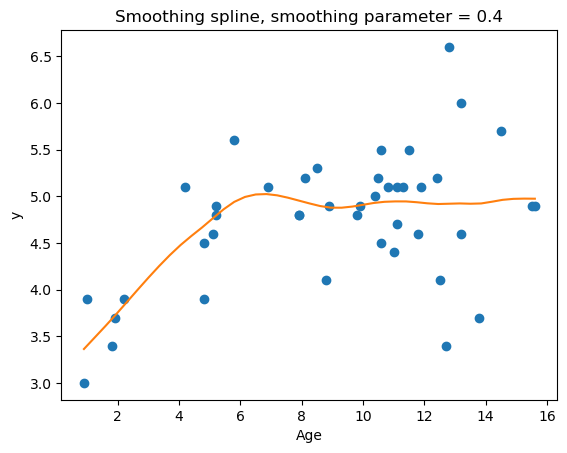

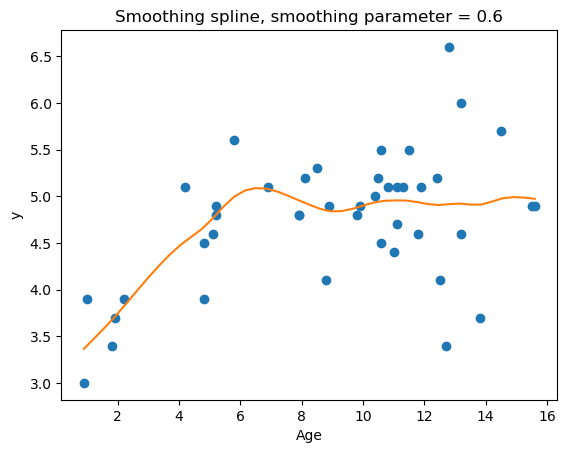

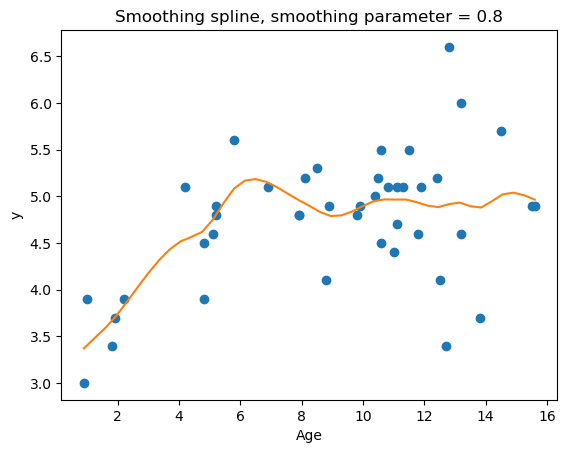

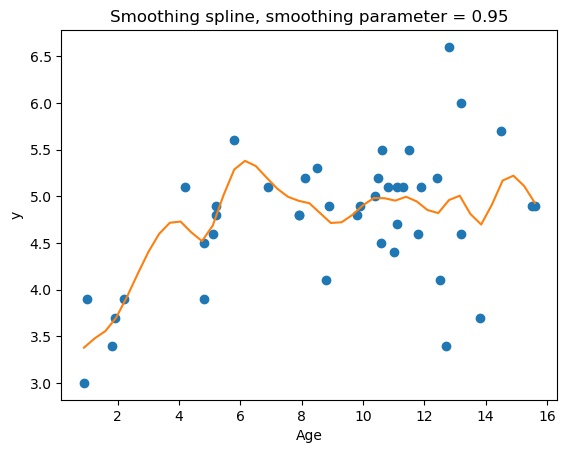

In [72]:
for cur_smoothing in [0, 0.2, 0.4, 0.6, 0.8, 0.95]:
    diab_sort = diab
    diab_sort['age'] = diab_sort['age']+np.random.normal(0,0.001, len(diab_sort)) 
    # ties not allowed (and the data is already sorted)
    diab_sort = diab.sort_values(['age']) # need to re-sort

    x = diab_sort['age']
    y = diab_sort['y']
    xs = np.linspace(min(x), max(x), len(x))
    ys = csaps(diab_sort['age'], diab_sort['y'], xs, smooth=cur_smoothing)

    plt.plot(x, y, 'o', xs, ys, '-')
    # !!!!!!!!! plot two things simultaneously
    
    plt.title("Smoothing spline, smoothing parameter = {}".format(cur_smoothing))
    plt.xlabel("Age")
    plt.ylabel("y")
    plt.show()

We can select the smoothing parameter by CV.

In [75]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])
kf = KFold(n_splits=2)
kf.get_n_splits(X)

print(kf)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

KFold(n_splits=2, random_state=None, shuffle=False)
Fold 0:
  Train: index=[2 3]
  Test:  index=[0 1]
Fold 1:
  Train: index=[0 1]
  Test:  index=[2 3]


In [73]:
from sklearn.model_selection import KFold

candidate_smoothings = [0, 0.2, 0.4, 0.6, 0.8, 0.95]

kf = KFold(n_splits=5, random_state=47, shuffle=True)
scores = np.zeros((5,len(candidate_smoothings)))

for i, (train_index, test_index) in enumerate(kf.split(diab_sort)):
    train_df = diab_sort.iloc[train_index,:]
    test_df = diab_sort.iloc[test_index,:]
    for j,cur_smoothing in enumerate(candidate_smoothings):
        train_df_sort = train_df.sort_values(['age'])
        test_df_sort = test_df.sort_values(['age'])
        x = train_df_sort['age']
        y = train_df_sort['y']
        xs = test_df_sort['age']
        ys = csaps(x,y,xs,smooth=cur_smoothing)
        scores[i,j] = sum((test_df['y']-ys)**2)
        
np.mean(scores, axis=0)

array([3.72896896, 3.54467388, 3.83511234, 4.12191615, 4.51819971,
       5.2211174 ])

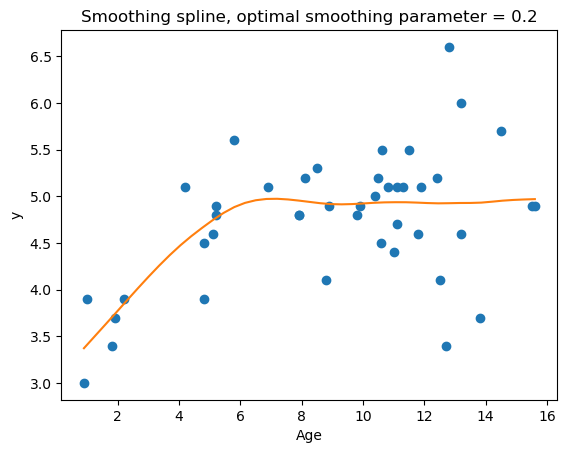

In [74]:
best_s = candidate_smoothings[np.argmin(np.mean(scores, axis=0))]
x = diab_sort['age']
y = diab_sort['y']
xs = np.linspace(min(x), max(x), len(x))
ys = csaps(diab_sort['age'], diab_sort['y'], xs, smooth=best_s)

plt.plot(x, y, 'o', xs, ys, '-')
plt.title("Smoothing spline, optimal smoothing parameter = {}".format(best_s))
plt.xlabel("Age")
plt.ylabel("y")
plt.show()

## B-Splines
Back to the diabetes data. First, let's see the data

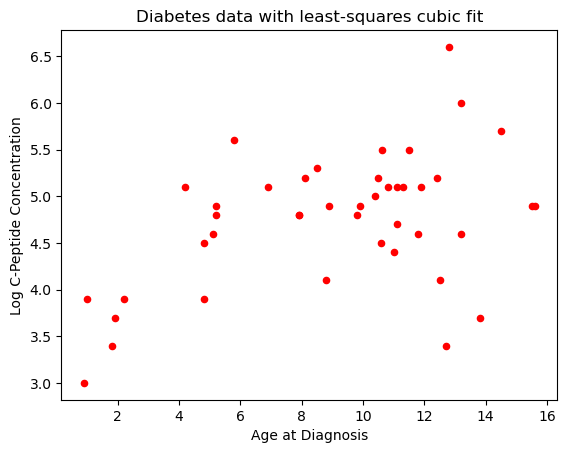

In [76]:
diab_sort = diab
diab_sort['age'] = diab_sort['age']+np.random.normal(0,0.001,len(diab_sort)) # again, ties not allowed
diab_sort = diab_sort.sort_values(['age'])

ax = diab_sort.plot.scatter(x='age',y='y',c='Red',title="Diabetes data with least-squares cubic fit")
ax.set_xlabel("Age at Diagnosis")
ax.set_ylabel("Log C-Peptide Concentration")
plt.show()


Get quartiles

In [77]:
quarts = diab_sort['age'].quantile([0.25, 0.5, 0.75]).values.reshape(-1)
# reshape(-1), not (-1,1)
# reshape(-1) flattening array into a 1D array.

Build a Bspline model. Call `splrep` (spline representation) to find the knots and coefficients that smooth the given data, then call BSpline to build something that can predict on given values. Notice that when we're done `b_spline_model` can be called like a function

In [84]:
from scipy.interpolate import splrep
from scipy.interpolate import BSpline

t,c,k = splrep(diab_sort['age'].values, diab_sort['y'].values, t=quarts)
# c  B-spline coefficients is a 1-D array-like object
# The coefficients determine the weights or magnitudes of influence that each control point has on the shape of the curve.
b_spline_model = BSpline(t,c,k)
b_spline_model(7)

array(4.99152191)

`LSQUnivariateSpline` fits splines to data, using user-specified knots

In [85]:
from scipy.interpolate import LSQUnivariateSpline

natural_spline_model = LSQUnivariateSpline(diab_sort['age'].values, diab_sort['y'].values, quarts)
# Fits a spline y = spl(x) of degree k to the provided x, y data. t (quarts) specifies the internal knots of the spline
# default k=3
# Unlike B-splines, which are defined by a set of control points and their associated coefficients, 
# univariate splines are defined by their knots and spline coefficients.

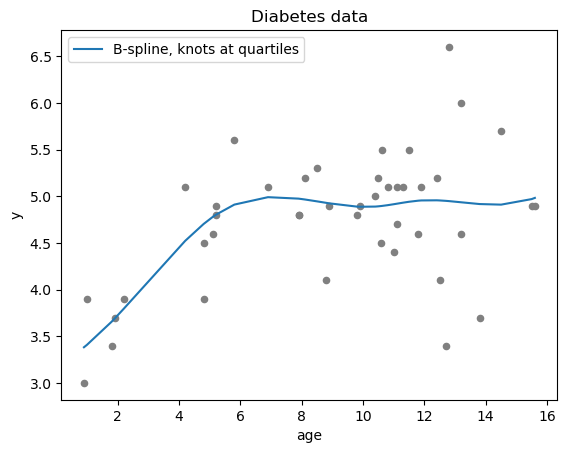

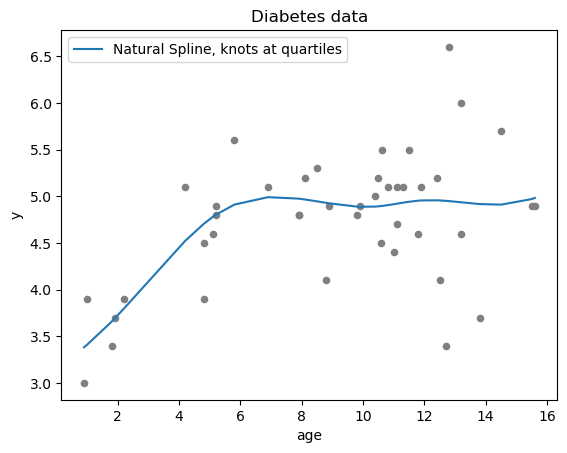

In [86]:
ax = diab_sort.plot.scatter(x='age',y='y',c='grey',title="Diabetes data")
ax.plot(diab_sort['age'], b_spline_model(diab_sort['age']), label="B-spline, knots at quartiles")
plt.legend()
plt.show()

ax = diab_sort.plot.scatter(x='age',y='y',c='grey',title="Diabetes data")
ax.plot(diab_sort['age'], natural_spline_model(diab_sort['age']), label="Natural Spline, knots at quartiles")
plt.legend()
plt.show()

## GAMs
Generalized Aditive Models essentially provide spline-like fits when there are multiple input variables.  We use the PyGam library, which relies on B-splines (really penalized B-splines, a.k.a. P-splines) as the smoother of choice.

Here we work with Kyphosis data, on 81 children who received a corrective spinal surgery. Each row records the child's age, the number of vertebrae operated on, the first vertebrae involved in the operation, and whether the operation was a success or experienced complications.

In [125]:
from sklearn.model_selection import train_test_split

kyphosis = pd.read_csv("../data/kyphosis.csv")
kyphosis["outcome"] = 1*(kyphosis["Kyphosis"] == "present")

kyph_train, kyph_test = train_test_split(kyphosis, test_size=.2, stratify=kyphosis['outcome'])

kyph_train.describe()

,Age,Number,Start,outcome
count,64.000000,64.000000,64.000000,64.000000
mean,84.406250,3.984375,12.000000,0.203125
std,58.732571,1.685533,4.649629,0.405505
min,1.000000,2.000000,1.000000,0.000000
25%,25.000000,3.000000,10.000000,0.000000
50%,89.000000,4.000000,13.000000,0.000000
75%,131.000000,5.000000,16.000000,0.000000
max,206.000000,10.000000,18.000000,1.000000


Using pygam is a lot like using the formula interface for statsmodels, but with raw code instead of with strings. Instead of `'s(Age)+s(Number)+s(Start)'` we have `s(0)+s(1)+s(2)` (the corresponding column indices). `s` is for 'smooth'. Each smooth accepts a `lam` parameter specifying the degree of smoothing. As before, larger lambdas mean smoother curves

In [126]:
from pygam import LogisticGAM, s

X = kyph_train[["Age","Number","Start"]]
y = kyph_train["outcome"]
kyph_gam = LogisticGAM(s(0)+s(1, lam=0.5)+s(2)).fit(X,y)
# the default smoothing penalty (lam=0.6

Correct classification rate is pretty good!

In [115]:
kyph_gam.accuracy(X,y)

0.921875

Summary of GAM fit on training data:

In [116]:
kyph_gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     12.4328
Link Function:                        LogitLink Log Likelihood:                                   -12.3985
Number of Samples:                           64 AIC:                                               49.6625
                                                AICc:                                              57.4851
                                                UBRE:                                               2.9314
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.6162
Feature Function                  Lam

/tmp/ipykernel_32171/3167408365.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  kyph_gam.summary()


GAMs provide plots of the effect of increasing each variable (conditional on / adjusted for the other variables)

In [101]:
kyph_gam.terms.feature

[0, 1, 2]

In [95]:
kyph_gam.generate_X_grid(term=1)

array([[ 0.        ,  2.        ,  0.        ],
       [ 0.        ,  2.08080808,  0.        ],
       [ 0.        ,  2.16161616,  0.        ],
       [ 0.        ,  2.24242424,  0.        ],
       [ 0.        ,  2.32323232,  0.        ],
       [ 0.        ,  2.4040404 ,  0.        ],
       [ 0.        ,  2.48484848,  0.        ],
       [ 0.        ,  2.56565657,  0.        ],
       [ 0.        ,  2.64646465,  0.        ],
       [ 0.        ,  2.72727273,  0.        ],
       [ 0.        ,  2.80808081,  0.        ],
       [ 0.        ,  2.88888889,  0.        ],
       [ 0.        ,  2.96969697,  0.        ],
       [ 0.        ,  3.05050505,  0.        ],
       [ 0.        ,  3.13131313,  0.        ],
       [ 0.        ,  3.21212121,  0.        ],
       [ 0.        ,  3.29292929,  0.        ],
       [ 0.        ,  3.37373737,  0.        ],
       [ 0.        ,  3.45454545,  0.        ],
       [ 0.        ,  3.53535354,  0.        ],
       [ 0.        ,  3.61616162,  0.   

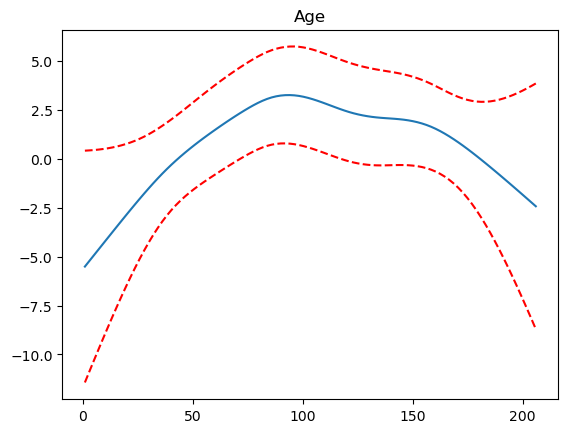

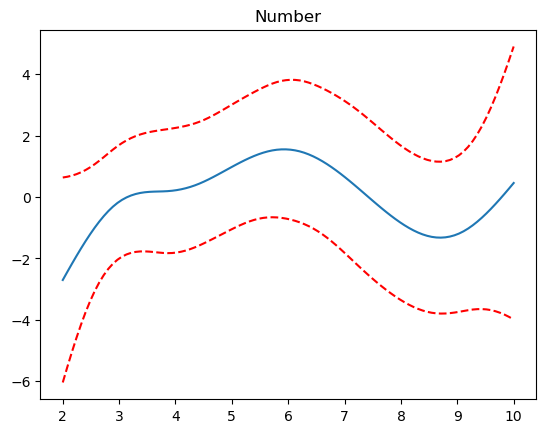

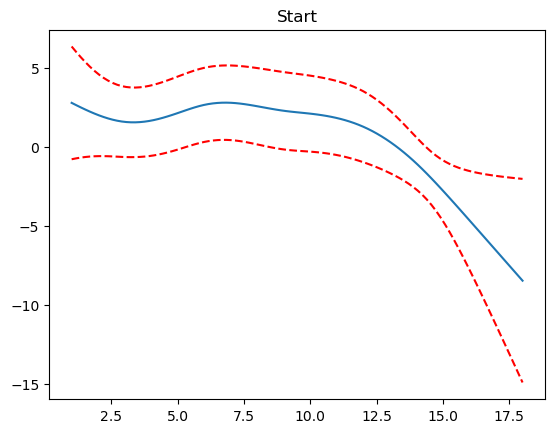

In [127]:
res = kyph_gam.deviance_residuals(X,y)
for i, term in enumerate(kyph_gam.terms):
    if term.isintercept:
        continue

    XX = kyph_gam.generate_X_grid(term=i)
    pdep, confi = kyph_gam.partial_dependence(term=i, X=XX, width=0.95)
    # A partial dependence function shows how the predicted outcome (target variable) changes as a specific predictor variable of interest varies, 
    # while holding all other predictor variables fixed at certain values or average values.
    # Term for which to compute the partial dependence functions.
    # width (float on (0, 1), optional) – Width of the confidence interval.
    # quantiles (array-like of floats on (0, 1), optional) – instead of specifying the prediciton width, one can specify the quantiles. so width=.95 is equivalent to quantiles=[.025, .975].
    # if both width=None and quantiles=None, then no confidence intervals are computed
    pdep2, _ = kyph_gam.partial_dependence(term=i, X=X, width=0.95)
    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X.columns.values[term.feature])
    plt.show()

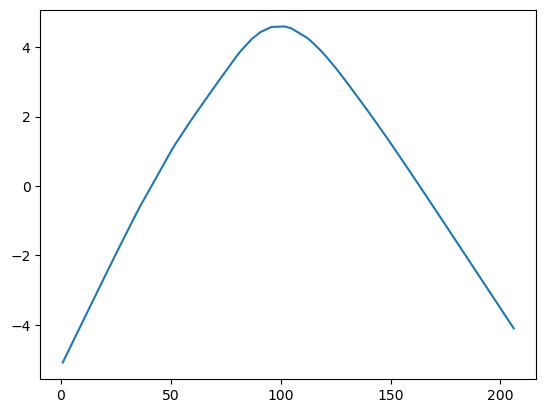

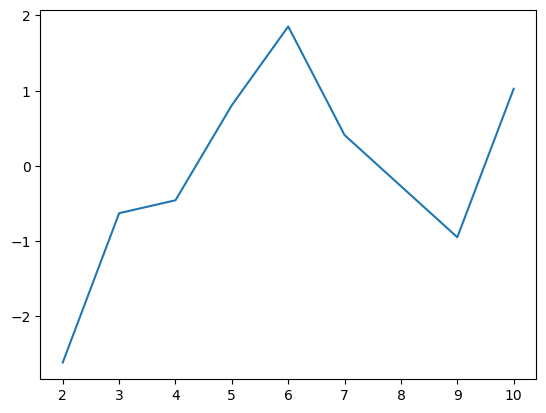

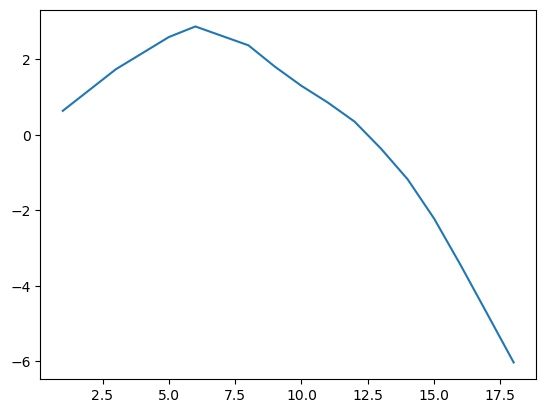

In [109]:
res = kyph_gam.deviance_residuals(X,y)
for i, term in enumerate(kyph_gam.terms):
    if term.isintercept:
        continue

    X = X.sort_values(X.columns[term.feature])
    pdep2, _ = kyph_gam.partial_dependence(term=i, X=X, width=0.95)
    
    plt.figure()
    plt.plot(X[X.columns[term.feature]], pdep2)
    # plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    # plt.title(X.columns.values[term.feature])
    plt.show()

Above, we see that as age ranges from 1 to 200 the chance of success first increases and then decreases, though with wide error bars. Moreover, we see that the Number of the vertebrae appears to have no effect or a mild effect until it reaches 12, and then drastically lowers.

Below, we try a model with only "Age" and "Start". In just a moment we'll compare the two models via cross-validation.

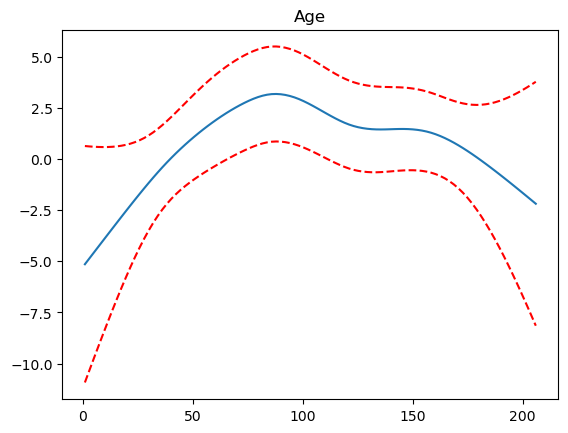

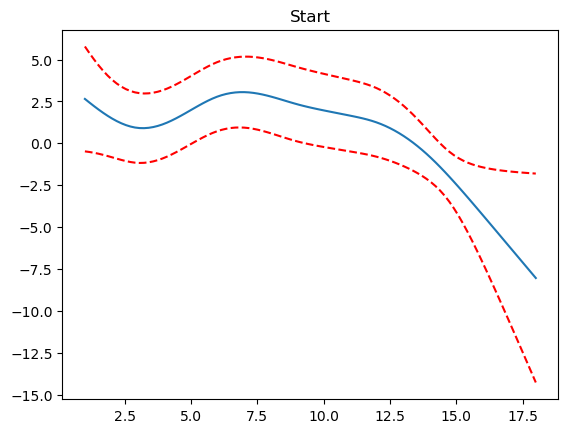

In [128]:
X = kyph_train[["Age","Number","Start"]]
y = kyph_train["outcome"]
small_kyph_gam = LogisticGAM(s(0)+s(2)).fit(X,y)


res = small_kyph_gam.deviance_residuals(X,y)
for i, term in enumerate(small_kyph_gam.terms):
    if term.isintercept:
        continue

    XX = small_kyph_gam.generate_X_grid(term=i)
    pdep, confi = small_kyph_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = small_kyph_gam.partial_dependence(term=i, X=X, width=0.95)
    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X.columns.values[term.feature])
    plt.show()

In [129]:
from sklearn.metrics import accuracy_score

X_test = kyph_test[["Age","Number","Start"]]
y_test = kyph_test["outcome"]

acc = accuracy_score(y_test, kyph_gam.predict(X_test))
acc_small = accuracy_score(y_test, small_kyph_gam.predict(X_test))

print("Test Accuracy m1: {:0.2f}, m2: {:0.2f}".format(acc, acc_small))

Test Accuracy m1: 0.71, m2: 0.59


We find that the richer model has a higher accuracy on the test set (it gets rid of one false positive present in the smaller model). Depending on taste, this may or may not be enough to declare the larger model the better.

A cross-validation (below) would make better use of the small data than a simple train-test split. (We again stratify on the outcome to ensure all test sets have a representative number of kyphosis cases)

Average accuracy [0.71617647 0.82794118]


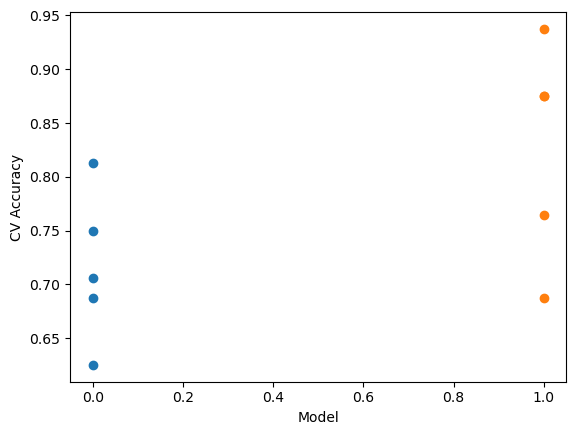

In [130]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, random_state=47, shuffle=True)
scores = np.zeros((5,2))

for i, (train_index, test_index) in enumerate(kf.split(kyphosis, kyphosis['outcome'])):
    # !!!!!!!!!!!
    train_df = kyphosis.iloc[train_index,:]
    test_df = kyphosis.iloc[test_index,:]
    
    # with all three (inserting lower smoothing on 'number' to prevent errors while fitting)
    cur_model_all = LogisticGAM(s(0)+s(1, lam=.5)+s(2)).fit(train_df[['Age', 'Number', 'Start']], train_df['outcome'])
    scores[i,0] = accuracy_score(test_df['outcome'], cur_model_all.predict(test_df[['Age', 'Number', 'Start']]))
    
    # dropping 'number'
    cur_model_some = LogisticGAM(s(0)+s(2)).fit(train_df[['Age', 'Number', 'Start']], train_df['outcome'])
    scores[i,1] = accuracy_score(test_df['outcome'], cur_model_some.predict(test_df[['Age', 'Number', 'Start']]))
        
print("Average accuracy", np.mean(scores, axis=0))
plt.scatter([0]*5, scores[:,0])
plt.scatter([1]*5, scores[:,1])
plt.xlabel("Model")
plt.ylabel("CV Accuracy")
plt.show()

As a naive average, it appears that the second model (without 'Number') is has the better accuracy. However, plotting the various CV scores shows that the two models aren't particularly different. As the test is inconclusive, one might choose the model without 'number' as it does not appear to be noticeably weaker, or one might stick with the richer model as it does not noticeably overfit.